In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
%matplotlib inline
from google.colab import files
uploaded = files.upload()

county_info = pd.read_csv('County_Info.csv', index_col=0)

Saving County_Info.csv to County_Info (2).csv


In [110]:
print(county_info.head())
print(county_info.shape)
county_numeric = county_info.select_dtypes(include=[np.number]).drop('county_fips', 1)

print(county_numeric.head())
county_numeric_data = county_numeric.values
print(county_numeric_data.shape)
counties = county_info['county_name'].to_list()
states = county_info['state_id'].to_list()
print(type(county_numeric_data))

   county_fips county_name  ... family_work unemployment_percentage
0         1001     Autauga  ...         0.1                     5.2
1         1003     Baldwin  ...         0.1                     5.5
2         1005     Barbour  ...         0.3                    12.4
3         1007        Bibb  ...         0.3                     8.2
4         1009      Blount  ...         0.1                     4.9

[5 rows x 45 columns]
(3214, 45)
         lat        lng  ...  family_work  unemployment_percentage
0  32.562500 -86.547800  ...          0.1                      5.2
1  30.554945 -87.723960  ...          0.1                      5.5
2  31.787050 -85.429850  ...          0.3                     12.4
3  33.059925 -87.145725  ...          0.3                      8.2
4  33.957085 -86.576808  ...          0.1                      4.9

[5 rows x 38 columns]
(3214, 38)
<class 'numpy.ndarray'>


In [56]:
def get_initial_centroids(data, k, seed=None):
    """
    Randomly choose k data points as initial centroids
    """
    if seed is not None: 
        np.random.seed(seed)
        
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
  
    centroids = data[rand_indices,:]
    
    return centroids

In [50]:
def assign_clusters(data, centroids):
    """
    Parameters:  
      - data      - is an np.array of float values of length N.  
      - centroids - is an np.array of float values of length k.

    Returns  
      -  A np.array of length N where the ith index represents which centroid 
         data[i] was assigned to. The assignments range between the values 0, ..., k-1.
    """
    return np.argmin(pairwise_distances(data, centroids), axis=1)

In [68]:
def revise_centroids(data, k, cluster_assignment):
    """
    Parameters:  
      - data               - is an np.array of float values of length N.
      - k                  - number of centroids
      - cluster_assignment - np.array of length N where the ith index represents which 
                             centroid data[i] was assigned to. The assignments range between the values 0, ..., k-1.

    Returns  
      -  A np.array of length k for the new centroids.
    """
    new_centroids = []
    for i in range(k):
        
        member_data_points = data[cluster_assignment == i]
        centroid = np.mean(member_data_points, axis=0)
        centroid = centroid.flatten()
        new_centroids.append(centroid)
        
    new_centroids = np.array(new_centroids)
    return new_centroids

In [69]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    """
    Computes the heterogeneity metric of the data using the given centroids and cluster assignments.
    """
    heterogeneity = 0.0
    for i in range(k):
        
        member_data_points = data[cluster_assignment==i,:]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data point
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [70]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    """
    This function runs k-means on given data and initial set of centroids.
    
    Parameters:  
      - data                 - is an np.array of float values of length N.
      - k                    - number of centroids
      - initial_centroids    - is an np.array of float values of length k.
      - maxiter              - maximum number of iterations to run the algorithm
      - record_heterogeneity - if provided an empty list, it will compute the heterogeneity 
                               at each iteration and append it to the list. 
                               Defaults to None and won't record heterogeneity.
      - verbose              - set to True to display progress. Defaults to False and won't 
                               display progress.

    Returns  
      - centroids - A np.array of length k for the centroids upon termination of the algorithm.
      - cluster_assignment - A np.array of length N where the ith index represents which 
                             centroid data[i] was assigned to. The assignments range between the 
                             values 0, ..., k-1 upon termination of the algorithm.
    """
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):  
        # Print itereation number
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment == cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment - cluster_assignment))
            if verbose:
                print('{} elements changed their cluster assignment.'.format(num_changed))  
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [54]:
def plot_heterogeneity(heterogeneity, k):
    """
    Plots how the heterogeneity changes as the number of iterations increases.
    """
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
881 elements changed their cluster assignment.
2
789 elements changed their cluster assignment.
3
581 elements changed their cluster assignment.
4
313 elements changed their cluster assignment.
5
195 elements changed their cluster assignment.
6
110 elements changed their cluster assignment.
7
69 elements changed their cluster assignment.
8
45 elements changed their cluster assignment.
9
29 elements changed their cluster assignment.
10
25 elements changed their cluster assignment.
11
19 elements changed their cluster assignment.
12
14 elements changed their cluster assignment.
13
12 elements changed their cluster assignment.
14
6 elements changed their cluster assignment.
15
8 elements changed their cluster assignment.
16
3 elements changed their cluster assignment.
17


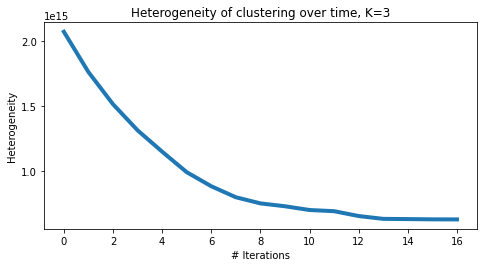

In [64]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(county_numeric_data, k, seed=0)
centroids, cluster_assignment = kmeans(county_numeric_data, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [74]:
def smart_initialize(data, k, seed=None):
    """
    Use k-means++ to initialize a good set of centroids
    """
    if seed is not None: 
        np.random.seed(seed)
        
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:]
    
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:]

        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

In [66]:
def kmeans_multiple_runs(data, k, maxiter, seeds, verbose=False):
    """
    Runs kmeans multiple times 
    
    Parameters:  
      - data    - is an np.array of float values of length N.
      - k       - number of centroids
      - maxiter - maximum number of iterations to run the algorithm
      - seeds   - Either number of seeds to try (generated randomly) or a list of seed values
      - verbose - set to True to display progress. Defaults to False and won't display progress.
    
    Returns  
      - final_centroids          - A np.array of length k for the centroids upon 
                                   termination of the algorithm.
      - final_cluster_assignment - A np.array of length N where the ith index represents which 
                                   centroid data[i] was assigned to. The assignments range between 
                                   the values 0, ..., k-1 upon termination of the algorithm.
    """    
    min_heterogeneity_achieved = float('inf')
    final_centroids = None
    final_cluster_assignment = None
    if type(seeds) == int:
        seeds = np.random.randint(low=0, high=10000, size=seeds)
    
    num_runs = len(seeds)
    
    for seed in seeds:

        initial_centroids = smart_initialize(data, k, seed=seed)
        
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter)

        seed_heterogeneity = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={}, heterogeneity={}'.format(seed, seed_heterogeneity))
            sys.stdout.flush()

        if seed_heterogeneity < min_heterogeneity_achieved:
            min_heterogeneity_achieved = seed_heterogeneity
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

Running k = 100
seed=20000, heterogeneity=7710205802830.482
seed=40000, heterogeneity=6169107775728.147
seed=80000, heterogeneity=6829475424442.315
Running k = 200
seed=20000, heterogeneity=2951244968678.4414
seed=40000, heterogeneity=2575254255686.849
seed=80000, heterogeneity=2332180277289.173
Running k = 250
seed=20000, heterogeneity=2189471972135.0913
seed=40000, heterogeneity=1534462539040.633
seed=80000, heterogeneity=1782880684965.533
Running k = 300
seed=20000, heterogeneity=1413902079635.5505
seed=40000, heterogeneity=1023051961205.5245
seed=80000, heterogeneity=1337764300204.869
Running k = 350
seed=20000, heterogeneity=943868031062.9688
seed=40000, heterogeneity=841730080368.7882
seed=80000, heterogeneity=1205887786658.6782
Running k = 400
seed=20000, heterogeneity=746925661145.9865
seed=40000, heterogeneity=692810771396.7808
seed=80000, heterogeneity=741012964839.8771
CPU times: user 1min 12s, sys: 38.7 s, total: 1min 51s
Wall time: 56.9 s


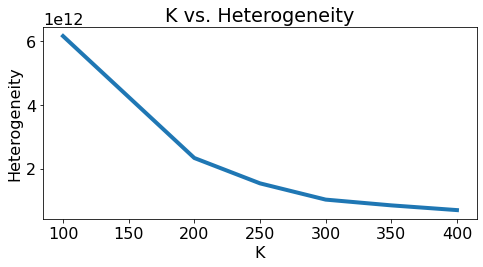

In [109]:
%%time

def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    """
    Given list of k-values and their heterogeneities, will make a plot
    showing how heterogeneity varies with k.
    """
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

all_centroids = {}
all_cluster_assignment = {}
heterogeneity_values = []
k_list = [100, 200, 250, 300, 350, 400]

for k in k_list:
    print('Running k = {}'.format(k))
    heterogeneity = []
    all_centroids[k], all_cluster_assignment[k] = kmeans_multiple_runs(county_numeric_data, k, maxiter=400,
                                                                       seeds=seeds, verbose=True)
    score = compute_heterogeneity(county_numeric_data, k, all_centroids[k], all_cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In [104]:
def visualize_city_clusters(dataframe, data, centroids, cluster_assignment, k, cities, 
                                display_docs=5):
    """
    
    Parameters:  
      - dataframe: cities
      - data: data matrix 
      - centroids: A np.array of length k that contains the centroids for the clustering
      - cluster_assignments: A np.array of length N that has the cluster assignments for each row
      - k: What value of k is used
      - cities: List of cities in the corpus (should match data)
      - display_odcs: How many documents to show for each cluster (default 5)
    """
    print('=' * 90)

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print(f'Cluster {c}  ({(cluster_assignment == c).sum()} docs)'),
        idx = centroids[c].argsort()[::-1]
        for i in range(5):
            print(f'{cities[idx[i]]}:{centroids[c,idx[i]]:.3f}', end=' '),
        print()
        
        if display_docs > 0:
            print()

            distances = pairwise_distances(data, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()

        print('=' * 90)

In [105]:
k = 100
visualize_document_clusters(county_numeric, county_numeric_data, all_centroids[k], all_cluster_assignment[k], k, county_info['county_name'].to_list())

Cluster 0  (138 docs)
Bibb:47979.500 Cleburne:40118.159 Colbert:22161.514 Blount:5577.341 Coffee:5267.391 

Cluster 1  (31 docs)
Blount:107800.226 Barbour:104966.935 Clay:80134.581 Butler:54569.323 Bullock:53230.903 

Cluster 2  (2 docs)
Blount:2487200.500 Barbour:2395312.500 Clay:1535864.500 Butler:1296298.500 Bullock:1190902.000 

Cluster 3  (21 docs)
Barbour:272373.095 Blount:197088.762 Clay:143057.190 Butler:99934.476 Bullock:97154.286 

Cluster 4  (5 docs)
Barbour:196470.800 Blount:110051.400 Clay:77008.000 Butler:55378.400 Bullock:54673.000 

Cluster 5  (2 docs)
Blount:1334316.000 Clay:951016.000 Barbour:922238.000 Butler:686123.500 Bullock:648192.500 

Cluster 6  (126 docs)
Cleburne:46436.468 Bibb:31101.175 Colbert:26621.770 Coffee:5148.230 Blount:4012.310 

Cluster 7  (33 docs)
Blount:68144.394 Barbour:59478.212 Clay:51260.455 Bibb:48354.424 Cleburne:45879.152 

Cluster 8  (3 docs)
Barbour:2670537.000 Blount:1347672.333 Clay:949717.667 Butler:693156.333 Bullock:654516.000 

Clu

In [81]:
np.set_printoptions(threshold=np.inf)
np.bincount(all_cluster_assignment[100])

array([138,  31,   2,  21,   5,   2, 126,  33,   3,   2,  10,   1,   4,
        76,   4,  37,   3,   3, 149,  82,   4,  37,   1,  38,  78,   8,
         1,   1,   9,  83,  32,   5,   2,  24,  77,   1,  11,   8,  10,
        30,  75,   9,  56,   3,   1,  36,   2,  45,   2,   4,   2, 103,
       107,   9,  22,  69,  20,  61, 102,  10,  22,   3,  16,  81, 131,
        58,  12,  15,  99,   1,   5,  34,  18,  17,  84,  24,  29,   1,
         9,  61,   5, 112,   4,  31,   1,   6,   1,   1,  20,  39,  34,
        29,   1,  33,   3,  66,  26,  20,   1, 131])

In [106]:
d = {'county': counties, 'state' : states, 'cluster': all_cluster_assignment[100]}
final_clusters = pd.DataFrame(data=d)
final_df = final_clusters.sort_values(by=['cluster'])

In [107]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

print_full(final_df)
final_df.to_csv('100clusters.csv', index=False)

                     county state  cluster
2161              Jefferson    OK        0
2375                    Day    SD        0
2377                  Dewey    SD        0
2735              Stonewall    TX        0
2380             Fall River    SD        0
2383                Gregory    SD        0
2737                Swisher    TX        0
2384                 Haakon    SD        0
2622                Haskell    TX        0
3121            Hot Springs    WY        0
2617               Hardeman    TX        0
2530                 Baylor    TX        0
2616               Hansford    TX        0
2392                Jackson    SD        0
2740                Terrell    TX        0
2615               Hamilton    TX        0
2394                  Jones    SD        0
2614                   Hall    TX        0
2733               Stephens    TX        0
1975                Tyrrell    NC        0
2372                 Corson    SD        0
2369                  Clark    SD        0
3032       